In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import mapping
import tracers as tr
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

[2025-03-18 14:32:48.968] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
Nodes 88690 edges 188608
[2025-03-18 14:32:49.947] [info] [network.cpp:172] Number of edges 188608 nodes 88690
[2025-03-18 14:32:49.947] [info] [network.cpp:173] Field index: id 20 source 0 target 1
[2025-03-18 14:32:50.136] [info] [network.cpp:176] Read network done.
[2025-03-18 14:32:50.222] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-18 14:32:50.248] [info] [network_graph.cpp:30] Graph nodes 88690 edges 188608
[2025-03-18 14:32:50.248] [info] [network_graph.cpp:31] Construct graph from network edges end


### Precompute an UBODT file

**This step can be skipped if you already created one UBODT file.**

In [ ]:
#from fmm import UBODTGenAlgorithm
#ubodt_gen = UBODTGenAlgorithm(network,graph)
#status = ubodt_gen.generate_ubodt("../osmnx_example/beijing/ubodt.txt", 4, binary=False, use_omp=True)
#print(status)

### Convert data to WKT
in this example, only the first 1000 points of taxi 156 are used

In [11]:
import pandas as pd
from shapely.geometry import LineString
import json
import os

with open('datapath.json', 'r') as f:
    data = json.load(f)

root_path = data['data_path']
user_path = 'taxi_7/taxi-7-rit-1.csv'
file_path = os.path.join(root_path, user_path)

# Use pandas to read the CSV file from the constructed path
df = pd.read_csv(file_path, sep=",")

# Convert to correct column names
df = df.rename(columns={"ID": "id", "Latitude": "x", "Longitude": "y", "Timestamp": "timestamp"})

# Convert timestamp to epoch
df["timestamp"] = pd.to_datetime(df["timestamp"]).astype(int) / 10**9
df["timestamp"] = df["timestamp"].astype(int)


linestring = LineString(zip(df["y"], df["x"]))  # WKT expects (lon, lat)
wkt_df = pd.DataFrame({"id": [df["id"].iloc[0]], "geom": [linestring.wkt]})
wkt_df.to_csv("../osmnx_example/rome/original_taxi_156.csv", sep=";", index=False)

# Apply perturbation
(space_noise, time_min_period) = (70.0, 30)
trace = df[['y', 'x', 'timestamp']].to_numpy()
trace = [tuple(x) for x in trace]
trace = [(x[0], x[1], int(x[2])) for x in trace]

perturbed_traces = tr.perturb_traces((space_noise, time_min_period), [trace])  
perturbed_trace = perturbed_traces[0]  

df_pert = pd.DataFrame(perturbed_trace, columns=["y", "x", "timestamp"])
df_pert["id"] = df["id"].iloc[0] 

print(len(perturbed_traces))

perturbed_linestring = LineString(zip(df_pert["y"], df_pert["x"])) 
wkt_df_pert = pd.DataFrame({"id": [df_pert["id"].iloc[0]], "geom": [perturbed_linestring.wkt]})
wkt_df_pert.to_csv("../osmnx_example/rome/pert_taxi_156.csv", sep=";", index=False)

1


### FMM model creation and map matching

match single trajectory

In [4]:
ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

[2025-03-18 14:32:57.031] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-18 14:32:58.051] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-18 14:32:58.932] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-18 14:32:59.956] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-18 14:33:00.824] [info] [ubodt.cpp:236] Read rows 4000000
[2025-03-18 14:33:01.660] [info] [ubodt.cpp:236] Read rows 5000000
[2025-03-18 14:33:02.632] [info] [ubodt.cpp:236] Read rows 6000000
[2025-03-18 14:33:03.604] [info] [ubodt.cpp:236] Read rows 7000000
[2025-03-18 14:33:04.633] [info] [ubodt.cpp:236] Read rows 8000000
[2025-03-18 14:33:05.784] [info] [ubodt.cpp:236] Read rows 9000000
[2025-03-18 14:33:06.797] [info] [ubodt.cpp:236] Read rows 10000000
[2025-03-18 14:33:07.785] [info] [ubodt.cpp:236] Read rows 11000000
[2025-03-18 14:33:08.642] [info] [ubodt.cpp:236] Read rows 12000000
[2025-03-18 14:33:09.473] [info] [ubodt.cpp:236] Read rows 13000000
[2025-0

In [12]:
df = pd.read_csv("../osmnx_example/rome/original_taxi_156.csv", sep=";")

#trajectory 156
wkt = df.loc[df["id"] == 7, "geom"].values[0]

print(wkt)
model = FastMapMatch(network,graph,ubodt)

# configuration parameters
k = 30

METER_PER_DEGREE = 109662.80313373724
# devide by 100_000 to go from meter to degrees
radius = 400/METER_PER_DEGREE
gps_error = 10/METER_PER_DEGREE

fmm_config = FastMapMatchConfig(k,radius,gps_error,perturbation=False, reverse_tolerance=0.5)

result = model.match_wkt(wkt,fmm_config)
print("Matched path: ", list(result.cpath))
print("Matched edge for each point: ", list(result.opath))
print("Matched edge index ",list(result.indices))
print("Matched geometry: ",result.mgeom.export_wkt())
print("Matched point ", result.pgeom.export_wkt())

gt = loads(result.mgeom.export_wkt())

LINESTRING (12.4929878655932 41.9096801874645, 12.4928867468692 41.9106604957526, 12.4928702435198 41.9107417070007, 12.4927445361592 41.911289256813, 12.4925123673749 41.9120709909908, 12.4925123673749 41.9120709909908, 12.4924403783379 41.9122590904999, 12.4933397449248 41.9134763386007, 12.4939903714973 41.9147343040499, 12.4941388740036 41.9155913138749, 12.4926227075983 41.9163367457581, 12.4911000026374 41.9172877058964, 12.4916026284695 41.9177232203516, 12.491656762973 41.9177646354738, 12.491656762973 41.9177646354738, 12.491656762973 41.9177646354738, 12.491656762973 41.9177646354738, 12.491656762973 41.9177646354738, 12.4917883899642 41.9178588927204, 12.4921769945269 41.9180294090743, 12.4932544365786 41.9172442054023, 12.4940803735008 41.9165070396735, 12.4940917035381 41.9153678406824, 12.4936512988969 41.9140772619139, 12.4927474158789 41.9127412571561, 12.4918012812199 41.911422892544, 12.4900959749643 41.9104609050955, 12.4894439920988 41.910154374911, 12.4894439920988

In [6]:
import folium
from shapely.wkt import loads

# original trace
original_geom = loads(wkt)

from geopy.distance import geodesic

for i in range(len(original_geom.coords) - 1):
    d = geodesic((original_geom.coords[i][1], original_geom.coords[i][0]), 
                 (original_geom.coords[i+1][1], original_geom.coords[i+1][0])).meters
    print(f"Distance from Point {i} to {i+1}: {d:.4f} meters")

print(original_geom.coords[6][1], original_geom.coords[6][0])
print(original_geom.coords[7][1], original_geom.coords[7][0])


m = folium.Map(location=[original_geom.coords[0][1], original_geom.coords[0][0]], zoom_start=16)

folium.PolyLine([(lat, lon) for lon, lat in original_geom.coords], color="red", weight=3).add_to(m)

for i, (lon, lat) in enumerate(original_geom.coords):
    folium.CircleMarker(location=[lat, lon], radius=3, color="red", fill=True, fill_color="red",popup=f"Point {i}").add_to(m)

# mm trace
if result.cpath:
    matched_geom = loads(result.mgeom.export_wkt())

    folium.PolyLine([(lat, lon) for lon, lat in matched_geom.coords], color="blue", weight=3, opacity=0.8, tooltip="Matched Path").add_to(m)
    
# Display map 
m

Distance from Point 0 to 1: 0.0000 meters
Distance from Point 1 to 2: 0.0000 meters
Distance from Point 2 to 3: 158.6267 meters
Distance from Point 3 to 4: 145.2968 meters
Distance from Point 4 to 5: 125.6027 meters
Distance from Point 5 to 6: 160.6670 meters
Distance from Point 6 to 7: 188.1163 meters
Distance from Point 7 to 8: 193.0279 meters
Distance from Point 8 to 9: 187.9023 meters
Distance from Point 9 to 10: 193.1714 meters
Distance from Point 10 to 11: 162.1543 meters
Distance from Point 11 to 12: 149.7784 meters
Distance from Point 12 to 13: 147.2065 meters
Distance from Point 13 to 14: 88.8421 meters
Distance from Point 14 to 15: 177.8799 meters
Distance from Point 15 to 16: 221.4016 meters
Distance from Point 16 to 17: 222.4318 meters
Distance from Point 17 to 18: 185.8550 meters
Distance from Point 18 to 19: 94.6216 meters
Distance from Point 19 to 20: 102.3245 meters
Distance from Point 20 to 21: 80.2568 meters
Distance from Point 21 to 22: 66.4589 meters
Distance from P

In [ ]:
import numpy as np 
import pandas as pd
import tracers as tr
import plotly.graph_objects as go
import matplotlib.pyplot as plt
df = pd.read_csv('../osmnx_example/rome/taxi_156.csv')
# covert timestamp to epoch
df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9
# sort by time
df = df.sort_values(by='Timestamp')
# to array on (lon,lat)
trace = df[['Longitude','Latitude','Timestamp']].to_numpy()
# take only 1000 points
trace = trace[7235:7250]
# trace holds tuples instead of arrays
trace = [tuple(x) for x in trace]
#time float to int
trace = [(x[0],x[1],int(x[2])) for x in trace]
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
    lat=[b for a,b,c in trace],
    lon=[a for a,b,c in trace],
    mode='lines+markers',
    marker=go.scattermapbox.Marker(
        size=9
    ),
    text=df['Timestamp']
))
center_of_rome = [41.9028, 12.4964]
fig.update_layout(mapbox_style="open-street-map",mapbox_center_lon=center_of_rome[1], mapbox_center_lat=center_of_rome[0],mapbox_zoom=10)
# fig.write_html(f"./outputs/example.html", auto_open=True)
fig.show()

### Map Matching after obfuscation

Matched path:  [53841, 11825, 53840, 107408, 53843, 130944, 35951, 169823, 169830, 164763, 35953, 91328, 169806, 136025, 14482, 129798, 62068, 119387, 119391, 152606, 844, 147960, 97981, 58418, 97985, 100908, 100914, 64293, 77393, 881, 826, 80417, 825, 828, 55112, 893, 41, 39, 58900, 25, 137546, 4638, 55102, 55111, 5916, 5914, 134800, 80299, 851, 150642, 150644, 153281, 153209, 828, 55112, 893, 41, 39, 58900, 24, 39013, 14542, 54, 25746, 109379, 89179, 64620, 25745, 85065, 111, 6747, 79696, 66310, 14547, 66328, 25756, 85063, 66312, 66326, 66310, 14547, 66328, 25756, 85064, 85065, 110, 4606, 11749, 1211, 1623, 71809, 14478, 73153, 38937, 96863, 11744, 96862, 16388, 93641, 4602, 1530, 110, 4606, 11749, 1211, 1623, 71809, 14479, 73151, 92772, 45046, 38936, 14307, 78259, 110570, 78272, 78271, 78268, 78262, 78264, 71996, 45042, 4712, 4684, 81110, 38957, 4704, 354, 4686, 4681, 117678, 4699, 16336, 4743, 4697, 38950, 8587, 82387, 8291, 25723, 82379, 69189, 135406, 8268, 62119, 11645, 11628, 6

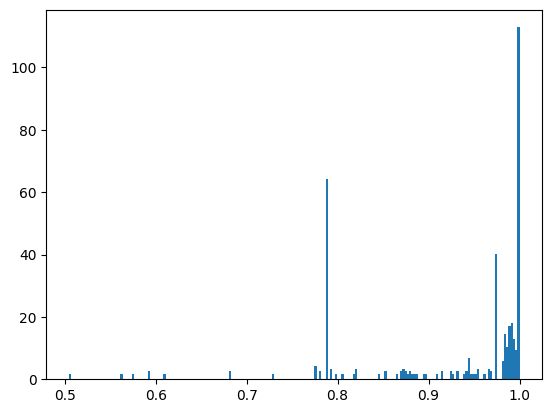

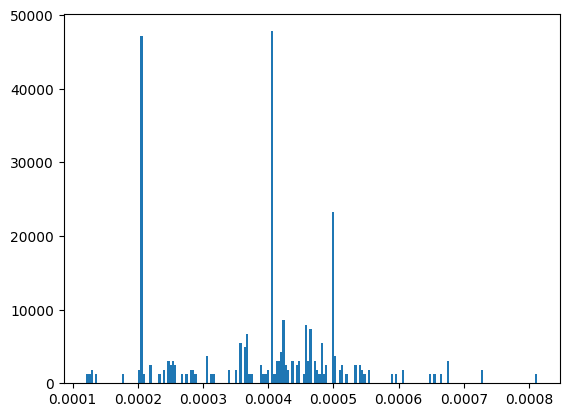

In [7]:
df = pd.read_csv("../osmnx_example/rome/pert_taxi_156.csv", sep=";")
df_original = pd.read_csv("../osmnx_example/rome/original_taxi_156.csv", sep=";")

wkt = df_original.loc[df_original["id"] == 7, "geom"].values[0]

#trajectory 156
wkt_pert = df.loc[df["id"] == 7, "geom"].values[0]

# configuration parameters
k = 15
# devide by +/- 100 000 to go from meter to degrees
radius = 400/METER_PER_DEGREE

gps_error = 10/METER_PER_DEGREE
obfuscation_error = 100/METER_PER_DEGREE

fmm_config = FastMapMatchConfig(k,radius,obfuscation_error,perturbation=True,reverse_tolerance=10)

result_pert = model.match_wkt(wkt_pert,fmm_config)
print("Matched path: ", list(result_pert.cpath))
print("Matched edge for each point: ", list(result_pert.opath))
print("Matched edge index ",list(result_pert.indices))
print("Matched geometry: ",result_pert.mgeom.export_wkt())
print("Matched point ", result_pert.pgeom.export_wkt())

# compare matched length to non obfuscated trace (considered ground truth)

intersection = gt.intersection(loads(result_pert.mgeom.export_wkt())).length
gt_length = gt.length
mm_length = loads(result_pert.mgeom.export_wkt()).length

# accuracy by length
precision = intersection/mm_length
print("Precision of map matching obfuscated data: ", precision)
recall = intersection/gt_length
print("Recall of map matching obfuscated data: ", recall)
f1 = (2*precision*recall)/(precision+recall)
print("F1-Score",f1)

ep_list = []
error_list = []
candidates = result_pert.candidates
for candidate in candidates:
    ep_list.append(candidate.ep)
    error_list.append(candidate.error)

plt.hist(ep_list,bins=200,density=True)
plt.show()

plt.hist(error_list,bins=200,density=True)
plt.show()

In [9]:
import folium
import pandas as pd
from shapely.wkt import loads

# Load data
df = pd.read_csv("../osmnx_example/rome/pert_taxi_156.csv", sep=";")
df_original = pd.read_csv("../osmnx_example/rome/original_taxi_156.csv", sep=";")

# Extract WKT geometry for trajectory ID 4
wkt_pert = df.loc[df["id"] == 7, "geom"].values[0]

# Convert WKT to Shapely LineString and extract coordinates
line = loads(wkt_pert)
coords = list(line.coords)  # List of (lon, lat)

# Slice points 210 to 230
coords_subset = coords 

# Create a Folium map centered at the first point in the subset
m = folium.Map(location=[coords_subset[0][1], coords_subset[0][0]], zoom_start=15)

# Add trajectory line for the subset
folium.PolyLine([(lat, lon) for lon, lat in coords_subset], color="red", weight=3).add_to(m)

d = geodesic((coords_subset[0][1], original_geom.coords[0][0]), 
            (original_geom.coords[1][1], original_geom.coords[1][0])).meters
print(f"Distance from Point {0} to {1}: {d:.4f} meters")

# Add numbered markers
for i, (lon, lat) in enumerate(coords_subset):
    folium.Marker(
        location=[lat, lon],
        popup=f"Point {i}",
        tooltip=f"Click for ID {i}"
    ).add_to(m)

m


Distance from Point 0 to 1: 35.2159 meters


In [13]:
import folium
from shapely.wkt import loads
from shapely.ops import unary_union

# Load your geometries
original_geom = loads(wkt)
pert_geom = loads(wkt_pert)
pert_matched_geom = loads(result_pert.mgeom.export_wkt())

# Compute the non-overlapping parts (difference)
gt_diff = matched_geom.difference(pert_matched_geom)  # Part of original_geom not in pert_geom
mm_diff = pert_matched_geom.difference(matched_geom)  # Part of pert_geom not in original_geom

# Combine the differences into one geometry
combined_diff = unary_union([gt_diff, mm_diff])

# Create the map centered around the first coordinate of the original geometry
m = folium.Map(location=[original_geom.coords[0][1], original_geom.coords[0][0]], zoom_start=16)

# Add the original, perturbed, and matched trajectories
folium.PolyLine([(lat, lon) for lon, lat in original_geom.coords], color="red", weight=3, opacity=0.8, tooltip="Original GPS Trajectory").add_to(m)
folium.PolyLine([(lat, lon) for lon, lat in pert_geom.coords], color="blue", weight=3, opacity=0.8, tooltip="Perturbed GPS Trajectory").add_to(m)
folium.PolyLine([(lat, lon) for lon, lat in pert_matched_geom.coords], color="green", weight=3, opacity=0.8, tooltip="Matched w perturbation").add_to(m)

# Add markers for each point in the original, perturbed, and matched geometries
for lon, lat in original_geom.coords:
    folium.CircleMarker(location=[lat, lon], radius=3, color="red", fill=True, fill_color="red").add_to(m)
for lon, lat in pert_geom.coords:
    folium.CircleMarker(location=[lat, lon], radius=3, color="blue", fill=True, fill_color="blue").add_to(m)

# Add the combined difference as a purple PolyLine
if not combined_diff.is_empty:
    if combined_diff.geom_type == 'LineString':
        # If it's a LineString, simply plot it
        folium.PolyLine([(lat, lon) for lon, lat in combined_diff.coords], color="purple", weight=3, opacity=0.8, tooltip="Difference").add_to(m)
    elif combined_diff.geom_type == 'MultiLineString':
        # If it's a MultiLineString, iterate through each LineString using .geoms
        for part in combined_diff.geoms:  # Access each LineString in the MultiLineString
            folium.PolyLine([(lat, lon) for lon, lat in part.coords], color="purple", weight=3, opacity=0.8, tooltip="Difference").add_to(m)

# Display map
m


In [ ]:
# error metric van https://doi.org/10.1145/1653771.1653818
# Load geometries from WKT
geom_gt = loads(result.mgeom.export_wkt())       # Ground truth matched geometry
geom_pert = loads(result_pert.mgeom.export_wkt()) # Perturbed matched geometry

# Compute correct route length (d0)
d0 = geom_gt.length

# Compute erroneously subtracted length (d-)
d_minus_geom = geom_gt.difference(geom_pert)
d_minus = d_minus_geom.length

# Compute erroneously added length (d+)
d_plus_geom = geom_pert.difference(geom_gt)
d_plus = d_plus_geom.length

# Compute the final error metric
error = (d_minus + d_plus) / d0

# Print results
print(f"Correct route length (d0): {d0:.2f}")
print(f"Erroneously subtracted (d-): {d_minus:.2f}")
print(f"Erroneously added (d+): {d_plus:.2f}")
print(f"Error metric: {error:.4f}")